In [1]:
#Data loading and Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np

IMG_SIZE = 128  

def load_images(data_dir):
    
    images = []
    labels = []
    
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        
        # Check if it's a directory
        if os.path.isdir(class_path):
            # Collect all .jpg and .jpeg files
            img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            
            for img_file in img_files:
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append((img, class_name))  # Store image and class name
                else:
                    print(f"Warning: Unable to load image {img_path}")

    return images

def remove_null_classes(images):
    """Removes null classes (classes with no images)."""
    
    filtered_images = [(img, label) for img, label in images if label]
    return filtered_images

def remove_outlier_classes(images, min_images=3):
    """Removes classes with fewer than or equal to min_images."""
    from collections import Counter
    class_counts = Counter([label for _, label in images])
    
   
    filtered_images = [(img, label) for img, label in images if class_counts[label] > min_images]
    
    for class_name, count in class_counts.items():
        if count <= min_images:
            print(f"Skipping '{class_name}' - too few images ({count} found)")

    return filtered_images

def resize_images(images):
    """Resizes images to the specified size (IMG_SIZE) and normalizes pixel values."""
    resized_images = []
    
    for img, label in images:
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to target size
        img_normalized = img_resized / 255.0  # Normalize pixel values
        resized_images.append((img_normalized, label))

    return resized_images


def encode_labels(images):
    """Encodes labels into numerical values and reduces memory usage."""
    labels = [label for _, label in images]
    
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_class_names = label_encoder.classes_
    
    print("Class names with their encoded values:")
    for index, class_name in enumerate(encoded_class_names):
        print(f"{class_name}: {index}")
    
    # Convert images to float32 for reduced memory usage
    encoded_images = [(img.astype(np.float32), encoded_label) for (img, _), encoded_label in zip(images, encoded_labels)]
    
   
    image_array = np.array([img for img, _ in encoded_images])
    label_array = np.array([label for _, label in encoded_images])
    
    return image_array, label_array, encoded_class_names


def preprocess_images(data_dir):
    """Main function to load, preprocess, and encode images and labels."""
    # Step 1: Load data
    images = load_images(data_dir)
    
    # Step 2: Remove null classes
    images = remove_null_classes(images)
    
    # Step 3: Remove outlier classes
    images = remove_outlier_classes(images)
    
    # Step 4: Resize and normalize images
    images = resize_images(images)
    
    # Step 5: Encode labels
    images, labels, class_names = encode_labels(images)
    
    print(f"Loaded {len(images)} images from {len(class_names)} valid classes.")
    
    return images, labels, class_names


DATA_DIR = r"D:\ML Project\Dataset"  # Update with your image directory path
images, labels, class_names = preprocess_images(DATA_DIR)

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
# Calculate total number of images in train and test sets
total_train_images = len(train_images)
total_test_images = len(test_images)
print("Images in train set: ", total_train_images)
print("Images in test set: ", total_test_images)

Skipping 'Tick' - too few images (1 found)
Class names with their encoded values:
Bear: 0
Brown bear: 1
Bull: 2
Butterfly: 3
Camel: 4
Canary: 5
Cat: 6
Caterpillar: 7
Cattle: 8
Centipede: 9
Cheetah: 10
Chicken: 11
Crab: 12
Crocodile: 13
Deer: 14
Dog: 15
Duck: 16
Eagle: 17
Elephant: 18
Fish: 19
Fox: 20
Frog: 21
Giraffe: 22
Goat: 23
Goldfish: 24
Goose: 25
Hamster: 26
Harbor seal: 27
Hedgehog: 28
Hippopotamus: 29
Horse: 30
Jaguar: 31
Jellyfish: 32
Kangaroo: 33
Koala: 34
Ladybug: 35
Leopard: 36
Lion: 37
Lizard: 38
Lynx: 39
Magpie: 40
Monkey: 41
Moths and butterflies: 42
Mouse: 43
Mule: 44
Ostrich: 45
Otter: 46
Owl: 47
Panda: 48
Parrot: 49
Penguin: 50
Pig: 51
Polar bear: 52
Rabbit: 53
Raccoon: 54
Raven: 55
Red panda: 56
Rhinoceros: 57
Scorpion: 58
Sea lion: 59
Sea turtle: 60
Seahorse: 61
Shark: 62
Sheep: 63
Shrimp: 64
Snail: 65
Snake: 66
Sparrow: 67
Spider: 68
Squid: 69
Squirrel: 70
Starfish: 71
Swan: 72
Tiger: 73
Tortoise: 74
Turkey: 75
Turtle: 76
Whale: 77
Woodpecker: 78
Worm: 79
Zebra: 80

In [17]:
#Model creation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

IMG_SIZE = 128  

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(train_images)

# Load the MobileNetV2 model pre-trained on ImageNet and exclude the top layer
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Unfreeze the base model layers for fine-tuning

# Freeze all but the last 20 layers for fine-tuning
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model with data augmentation and callbacks
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr , early_stop]
)

# Print the final training  accuracy
train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")




Epoch 1/50


C:\Users\kesha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 158s 700ms/step - accuracy: 0.0576 - loss: 5.0193 - val_accuracy: 0.3105 - val_loss: 3.1783 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 620ms/step - accuracy: 0.2587 - loss: 3.3927 - val_accuracy: 0.4470 - val_loss: 2.4272 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 106s 630ms/step - accuracy: 0.3847 - loss: 2.7267 - val_accuracy: 0.5065 - val_loss: 2.0826 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 620ms/step - accuracy: 0.4335 - loss: 2.3901 - val_accuracy: 0.5492 - val_loss: 1.8459 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 103s 612ms/step - accuracy: 0.4858 - loss: 2.1416 - val_accuracy: 0.5751 - val_loss: 1.6968 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 103s 611ms/step - accuracy: 0.5513 - loss: 1.8685 - val_accuracy: 0.5843 - val_loss: 1.6173 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 624ms/

In [24]:
model.save(r"D:\MLProject.keras")
print("Model is saved")

Model is saved


In [3]:
from tensorflow.keras.models import load_model
model = load_model(r"D:\MLProject.keras")
print("Model is loaded")


Model is loaded


C:\Users\kesha\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 29 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


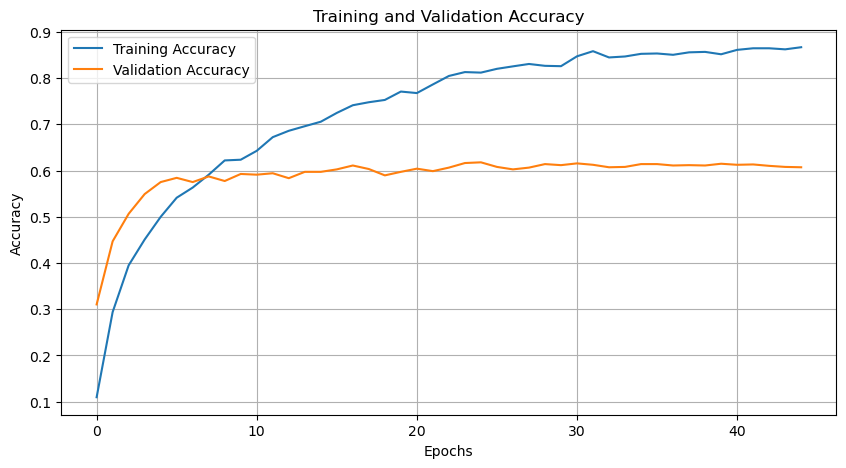

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step


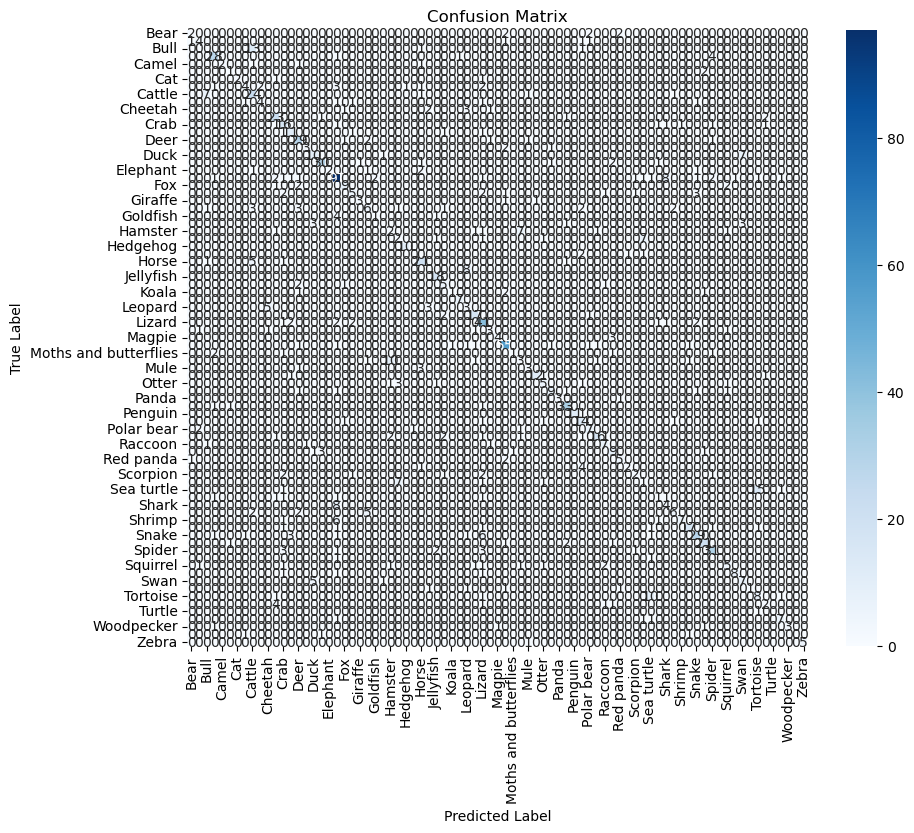

In [28]:
#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_accuracy(history):
   
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



plot_accuracy(history)

# Get predictions on the test set
test_predictions = model.predict(test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_pred_classes, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


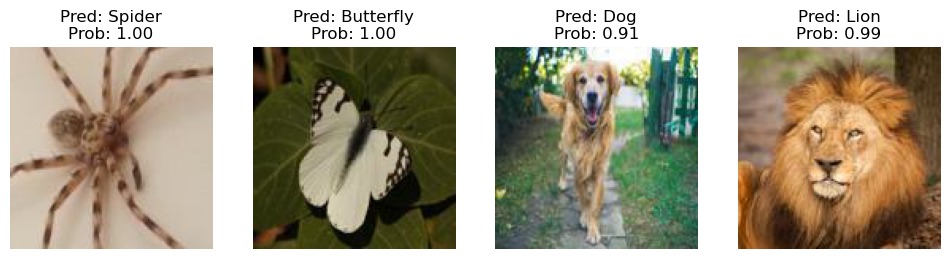

In [38]:
#Model Evaluation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_classes(model, img_paths, class_names, img_size=128):
    
    predictions = []
    probabilities = []
    images = []
    
    for img_path in img_paths:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_size, img_size))  # Resize to 128x128
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  
        img_array /= 255.0  
        
        # Predict the class probabilities
        pred = model.predict(img_array)
        
        # Get the predicted class index and probability
        pred_class_index = np.argmax(pred, axis=1)[0]
        pred_probability = np.max(pred)
        
        # Convert the class index to the class name
        predicted_class = class_names[pred_class_index]
        
        predictions.append(predicted_class)
        probabilities.append(pred_probability)
        images.append(img)
    
    return predictions, probabilities, images

def display_predictions(img_paths, predictions, probabilities, images):
   
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {predictions[i]}\nProb: {probabilities[i]:.2f}")
    plt.show()

#Example
img_paths = [r"D:\ML Project\Dataset\Spider\4f18c7010cc3f63a.jpg" , r"D:\ML Project\Dataset\Butterfly\0ba8dea9487e3833.jpg" ,r"D:\ML Project\Dataset\Dog\berkay-gumustekin-Crj3gU0aJsU-unsplash.jpg",r"D:\ML Project\Dataset\Lion\0149d723dbc0d724.jpg"]
predictions, probabilities, images = predict_classes(model, img_paths, class_names)
display_predictions(img_paths, predictions, probabilities, images)

In [5]:
#CNN model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit generator on the training data
datagen.fit(train_images)


# Convert labels to categorical format for multi-class classification
num_classes = len(class_names)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Define the CNN model
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential([
        # First convolutional layer with batch normalization and max pooling
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional layer
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fourth convolutional layer
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and add dense layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),  # Dropout for regularization

        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


# Train the model
history = model.fit(
    train_images, train_labels,
    epochs=35,  # Start with 20 epochs and adjust based on performance
    batch_size=32,  # Batch size for efficient training
    validation_data=(test_images, test_labels),
    verbose=1
)


acc = history.history['accuracy'][-1]
print(f"Final Test Accuracy: {acc * 100:.2f}%")


C:\Users\kesha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 81)             │        10,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,073 (6.03 MB)

 Trainable params: 1,579,857 (6.03 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 116s 631ms/step - accuracy: 0.0718 - loss: 4.7485 - val_accuracy: 0.0542 - val_loss: 5.0619
Epoch 2/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 604ms/step - accuracy: 0.1378 - loss: 3.9350 - val_accuracy: 0.0664 - val_loss: 4.4548
Epoch 3/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.1961 - loss: 3.4850 - val_accuracy: 0.1670 - val_loss: 3.6738
Epoch 4/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.2472 - loss: 3.1174 - val_accuracy: 0.1998 - val_loss: 3.4703
Epoch 5/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 98s 597ms/step - accuracy: 0.3064 - loss: 2.8147 - val_accuracy: 0.2265 - val_loss: 3.2523
Epoch 6/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 609ms/step - accuracy: 0.3583 - loss: 2.5204 - val_accuracy: 0.2304 - val_loss: 3.1816
Epoch 7/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 607ms/step - accuracy: 0.4276 - loss: 2.1899 - val_accuracy: 0.2441 - val_loss: 3.1776
Epoch 8/35
164/164 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.5507 - loss

In [7]:
# Print the final accuracy
acc = history.history['accuracy'][-1]
print(f"Final Test Accuracy: {acc * 100:.2f}%")

Final Test Accuracy: 90.98%


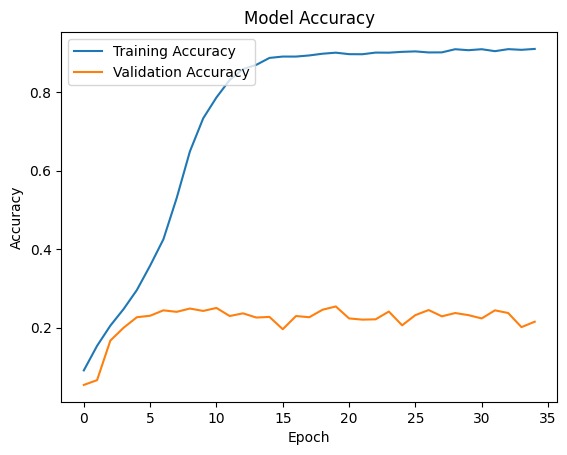

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_accuracy(history)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


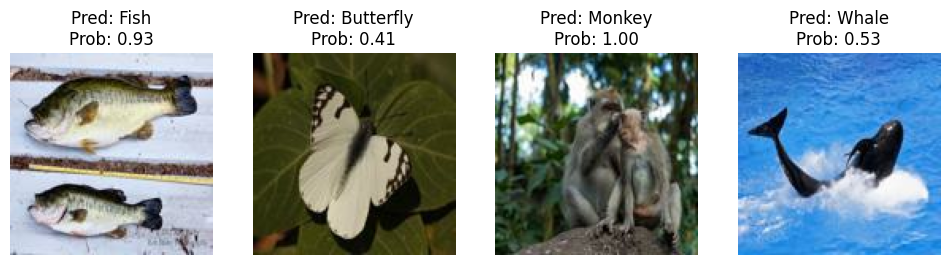

In [35]:
# Model Evaluation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_classes(model, img_paths, class_names, img_size=128):
   
    predictions = []
    probabilities = []
    images = []
    
    for img_path in img_paths:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_size, img_size))  # Resize to target size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  
        img_array /= 255.0  # Normalize to [0, 1]
        
        # Predict the class probabilities
        pred = model.predict(img_array)
        
        # Get the predicted class index and probability
        pred_class_index = np.argmax(pred, axis=1)[0]
        pred_probability = np.max(pred)
        
        # Convert the class index to the class name
        predicted_class = class_names[pred_class_index]
        
        predictions.append(predicted_class)
        probabilities.append(pred_probability)
        images.append(img)
    
    return predictions, probabilities, images

def display_predictions(img_paths, predictions, probabilities, images):
   
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {predictions[i]}\nProb: {probabilities[i]:.2f}")
    plt.show()

# Example 
img_paths = [
    r"D:\ML Project\Dataset\Fish\0ac9487aec65bc89.jpg",
    r"D:\ML Project\Dataset\Butterfly\0ba8dea9487e3833.jpg",
    r"D:\ML Project\Dataset\Monkey\6dc92667d0677264.jpg",
    r"D:\ML Project\Dataset\Whale\33d0166ea034abde.jpg"
]
predictions, probabilities, images = predict_classes(model, img_paths, class_names)
display_predictions(img_paths, predictions, probabilities, images)
